# Analyzing the 19-20 Miami Heat's playoff performance

After the sudden emergence of COVID-19 which brought an abrupt end to the season, the Miami squad went from 5th in the Eastern Conference standings to becoming championship contenders during the NBA 2020 Bubble, bringing the Lakers to an unpredictable game 6 that people never thought should've happened in the first place.

We will compare the team's performance from the regular season to their playoff performance, deciding whether their postseason performance is something that could've been predicted from their regular season stats or if it was simply a unlikely miracle. We focus on using Dean Oliver's four factors, published in his book *Basketball on Paper*, as our key features.

Let us collect the data. We use the NBA API library provided here: https://github.com/swar/nba_api. 

In [1]:
import numpy as np 
import pandas as pd 
import os
import scipy
import scipy.stats as stats
from nba_api.stats.endpoints import teamgamelog, teamgamelogs, boxscoresummaryv2,leaguegamelog, boxscoreadvancedv2
from nba_api.stats.static import teams
import matplotlib.pyplot as plt

In [2]:
current_teams_abbr = ['ATL',
                'BKN',
                'BOS',
                'CHA',
                'CHI',
                'CLE',
                'DAL',
                'DEN',
                'DET',
                'DET',
                'GSW',
                'HOU',
                'IND',
                'LAC',
                'LAL',
                'MEM',
                'MIA',
                'MIL',
                'MIN',
                'NOP',
                'NYK',
                'OKC',
                'ORL',
                'PHI',
                'PHX',
                'POR',
                'SAC',
                'SAS',
                'TOR',
                'UTA',
                'WAS']
team_ids = {}
for abbr in current_teams_abbr:
    team_ids[abbr] = teams.find_team_by_abbreviation(abbr)['id']
team_ids

{'ATL': 1610612737,
 'BKN': 1610612751,
 'BOS': 1610612738,
 'CHA': 1610612766,
 'CHI': 1610612741,
 'CLE': 1610612739,
 'DAL': 1610612742,
 'DEN': 1610612743,
 'DET': 1610612765,
 'GSW': 1610612744,
 'HOU': 1610612745,
 'IND': 1610612754,
 'LAC': 1610612746,
 'LAL': 1610612747,
 'MEM': 1610612763,
 'MIA': 1610612748,
 'MIL': 1610612749,
 'MIN': 1610612750,
 'NOP': 1610612740,
 'NYK': 1610612752,
 'OKC': 1610612760,
 'ORL': 1610612753,
 'PHI': 1610612755,
 'PHX': 1610612756,
 'POR': 1610612757,
 'SAC': 1610612758,
 'SAS': 1610612759,
 'TOR': 1610612761,
 'UTA': 1610612762,
 'WAS': 1610612764}

In [3]:
def create_season_games_df(team_abbr: str):
    regseason = leaguegamelog.LeagueGameLog (counter = None, direction = 'ASC', league_id = '00',player_or_team_abbreviation = 'T', season='2019-20', season_type_all_star= 'Regular Season',sorter = 'DATE') 
    regseason = regseason.get_data_frames()[0]
    team_regseason = regseason[regseason['TEAM_ABBREVIATION'].str.contains(team_abbr)]
    opp_regseason = regseason[~regseason['TEAM_ABBREVIATION'].str.contains(team_abbr)]
    opp_regseason = opp_regseason.add_prefix('OPP_')
    team_regseason_full = team_regseason.join(opp_regseason.set_index('OPP_GAME_ID'), on= 'GAME_ID', how = 'left')
    return team_regseason_full
mia_regseason_full = create_season_games_df('MIA')
ind_regseason_full = create_season_games_df('IND')
bos_regseason_full = create_season_games_df('BOS')
lal_regseason_full = create_season_games_df('LAL')

In [4]:
playoffs = leaguegamelog.LeagueGameLog (counter = 1, direction = 'ASC', league_id = '00',player_or_team_abbreviation = 'T', season='2019-20', season_type_all_star= 'Playoffs',sorter = 'DATE') 
playoffs = playoffs.get_data_frames()[0]
mia_playoffs = playoffs[playoffs['TEAM_ABBREVIATION'].str.contains('MIA')]
opp_playoffs = playoffs[~playoffs['TEAM_ABBREVIATION'].str.contains('MIA')]
opp_playoffs = opp_playoffs.add_prefix('OPP_')
mia_playoffs_full = mia_playoffs.join(opp_playoffs.set_index('OPP_GAME_ID'), on= 'GAME_ID', how = 'left')
mia_playoffs_full

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,OPP_DREB,OPP_REB,OPP_AST,OPP_STL,OPP_BLK,OPP_TOV,OPP_PF,OPP_PTS,OPP_PLUS_MINUS,OPP_VIDEO_AVAILABLE
15,42019,1610612748,MIA,Miami Heat,0041900131,2020-08-18,MIA @ IND,W,240,40,...,30,37,22,7,4,15,23,101,-12,1
29,42019,1610612748,MIA,Miami Heat,0041900132,2020-08-20,MIA @ IND,W,240,36,...,34,38,25,12,7,17,23,100,-9,1
46,42019,1610612748,MIA,Miami Heat,0041900133,2020-08-22,MIA vs. IND,W,240,34,...,30,37,23,10,5,14,31,115,-9,1
58,42019,1610612748,MIA,Miami Heat,0041900134,2020-08-24,MIA vs. IND,W,240,40,...,29,34,20,8,6,15,16,87,-12,1
82,42019,1610612748,MIA,Miami Heat,0041900201,2020-08-31,MIA @ MIL,W,240,39,...,27,34,22,6,7,19,24,104,-11,1
88,42019,1610612748,MIA,Miami Heat,0041900202,2020-09-02,MIA @ MIL,W,240,37,...,33,50,16,6,2,14,25,114,-2,1
96,42019,1610612748,MIA,Miami Heat,0041900203,2020-09-04,MIA vs. MIL,W,240,35,...,36,44,23,8,5,10,22,100,-15,1
105,42019,1610612748,MIA,Miami Heat,0041900204,2020-09-06,MIA vs. MIL,L,265,40,...,37,46,25,10,4,12,20,118,3,1
113,42019,1610612748,MIA,Miami Heat,0041900205,2020-09-08,MIA @ MIL,W,240,35,...,28,41,20,7,5,11,23,94,-9,1
133,42019,1610612748,MIA,Miami Heat,0041900301,2020-09-15,MIA @ BOS,W,265,40,...,31,37,24,9,6,11,25,114,-3,1


# Dean Oliver's Four Factors

In *Basketball on Paper*, Dean Oliver discussed four key statistical features that he thought we were the biggest determinants for the outcome of a basketball game:
- Effective Field Goal Percentage (eFG%)
- Turnover Percentage (TOV%)
- Offensive Rebounding Percentage (ORB%)
- Free Throw Rate (FTRate)

These stats best measure how efficiently teams score and retain possessions. Below, we engineer the feature columns for both teams in each game to determine how well the Heat are in performing as well as preventing other teams from succeeding within these metrics.

## Effective Field Goal Percentage

In [5]:
def create_eFG(df):
    df['eFG%'] = 100 * (df['FGM'] + df['FG3M']*0.5)/df['FGA']
    return df

In [6]:
def create_opp_eFG(df):
    df['OPP_eFG%'] = 100 * (df['OPP_FGM'] + df['OPP_FG3M']*0.5)/df['OPP_FGA']
    return df

## Turnover Percentage

In [7]:
def create_tov(df):
    df['TOV%'] = 100 * df['TOV']/(df['FGA'] + df['FTA']*0.44 + df['TOV'])
    return df

def create_opp_tov(df):
    df['OPP_TOV%'] = 100 * df['OPP_TOV']/(df['OPP_FGA'] + df['OPP_FTA']*0.44 + df['OPP_TOV'])
    return df

## Rebounding Percentage

### Offensive Rebounding Percentage

In [8]:
def create_orb(df):
    df['ORB%'] = df['OREB']/(df['OREB'] + df['OPP_DREB'])
    return df

### Opponent Offensive Rebounding Percentage (1 - Defensive Rebounding Percentage)

In [9]:
def create_opp_orb(df):
    df['OPP_ORB%'] = df['OPP_OREB']/(df['OPP_OREB'] + df['DREB'])
    return df

## Free Throw Rate (FTM/FGA)
Some people like to interpret free throw rate as the number of free throw attempts over field goal attempts, but here we change the numerator to be the number of free throws made. This not only captures how often the team reaches the free throw line, but also how often they make it.

In [10]:
def create_ftrate(df):
    df['FTRate'] = df['FTM']/df['FGA']
    return df

def create_opp_ftrate(df):
    df['OPP_FTRate'] = df['OPP_FTM']/df['OPP_FGA']
    return df

## Creating Feature Columns

In [66]:
def create_four_factors(df):
    df = create_eFG(df)
    df = create_opp_eFG(df)
    df = create_tov(df)
    df = create_opp_tov(df)
    df = create_orb(df)
    df = create_opp_orb(df)
    df = create_ftrate(df)
    df = create_opp_ftrate(df)
    return df

advstats = ['TEAM_ID', 
            'WL', 
            'eFG%', 
            'OPP_eFG%', 
            'TOV%', 
            'OPP_TOV%', 
            'ORB%', 
            'OPP_ORB%' , 
            'FTRate', 
            'OPP_FTRate', 
            'eFG%_diff',
           'TOV%_diff',
           'ORB%_diff',
           'FTRate_diff',
           'FourFactorAdv']

In [12]:
mia_regseason_full = create_four_factors(mia_regseason_full)
ind_regseason_full = create_four_factors(ind_regseason_full)
bos_regseason_full = create_four_factors(bos_regseason_full)
lal_regseason_full = create_four_factors(lal_regseason_full)

We compare the difference between their own performance in the Four Factors with the other team, because in order to win, you don't to perform highly or score too many points, you just need to perform better than the other team.

In [13]:
mia_regseason_full['eFG%_diff'] = mia_regseason_full['eFG%'] -  mia_regseason_full['OPP_eFG%']
mia_regseason_full['TOV%_diff'] = mia_regseason_full['OPP_TOV%'] - mia_regseason_full['TOV%']  
mia_regseason_full['ORB%_diff'] = mia_regseason_full['ORB%'] -  mia_regseason_full['OPP_ORB%']
mia_regseason_full['FTRate_diff'] = mia_regseason_full['FTRate'] -  mia_regseason_full['OPP_FTRate']

In [90]:
def calc_fourfactor_score(row):
    """
    Calculates how many of the four factors that the team of interest outperforms the opposing team in
    Used as a row function within df.apply
    """
    score = 0
    cols = ['eFG%_diff', 'TOV%_diff', 'ORB%_diff', 'FTRate_diff']
    for col in cols:
        if row[col]>0:
            score+=1
        elif row[col] < 0:
            score -=1
    return score
        

mia_regseason_full['FourFactorAdv'] = mia_regseason_full.apply(calc_fourfactor_score, axis = 1)
ind_regseason_full['FourFactorAdv'] = ind_regseason_full.apply(calc_fourfactor_score, axis = 1)

mia_regseason_full

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,OPP_TOV%,ORB%,OPP_ORB%,FTRate,OPP_FTRate,eFG%_diff,TOV%_diff,ORB%_diff,FTRate_diff,FourFactorAdv
20,22019,1610612748,MIA,Miami Heat,0021900007,2019-10-23,MIA vs. MEM,W,240,40,...,19.017433,0.261905,0.183673,0.388235,0.224719,5.670853,1.966442,0.078231,0.163516,4
57,22019,1610612748,MIA,Miami Heat,0021900026,2019-10-26,MIA @ MIL,W,265,46,...,14.128728,0.160000,0.098039,0.227723,0.287234,0.805772,0.779574,0.061961,-0.059511,2
73,22019,1610612748,MIA,Miami Heat,0021900039,2019-10-27,MIA @ MIN,L,240,42,...,13.166557,0.179487,0.291667,0.117647,0.274725,8.235294,-6.903251,-0.112179,-0.157078,-2
104,22019,1610612748,MIA,Miami Heat,0021900052,2019-10-29,MIA vs. ATL,W,240,33,...,17.611835,0.351351,0.200000,0.452055,0.192771,5.314408,-5.566973,0.151351,0.259284,2
133,22019,1610612748,MIA,Miami Heat,0021900066,2019-10-31,MIA @ ATL,W,240,40,...,13.860014,0.209302,0.333333,0.142857,0.204545,11.066017,0.697171,-0.124031,-0.061688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,22019,1610612748,MIA,Miami Heat,0021901269,2020-08-06,MIA @ MIL,L,240,35,...,12.877116,0.133333,0.131579,0.301205,0.423077,-7.360210,-3.807113,0.001754,-0.121872,-2
2046,22019,1610612748,MIA,Miami Heat,0021901283,2020-08-08,MIA vs. PHX,L,240,41,...,9.838998,0.069767,0.260870,0.226190,0.206522,1.009317,-1.516036,-0.191102,0.019669,0
2064,22019,1610612748,MIA,Miami Heat,0021901295,2020-08-10,MIA vs. IND,W,240,44,...,15.178571,0.250000,0.115385,0.132653,0.190476,6.292517,3.546800,0.134615,-0.057823,2
2088,22019,1610612748,MIA,Miami Heat,0021901306,2020-08-12,MIA @ OKC,L,240,42,...,13.689254,0.142857,0.291667,0.197674,0.247191,4.167755,2.453299,-0.148810,-0.049517,0


In [14]:
ind_regseason_full['eFG%_diff'] = ind_regseason_full['eFG%'] -  ind_regseason_full['OPP_eFG%']
ind_regseason_full['TOV%_diff'] = ind_regseason_full['OPP_TOV%'] - ind_regseason_full['TOV%']  
ind_regseason_full['ORB%_diff'] = ind_regseason_full['ORB%'] -  ind_regseason_full['OPP_ORB%']
ind_regseason_full['FTRate_diff'] = ind_regseason_full['FTRate'] -  ind_regseason_full['OPP_FTRate']

# Running Statistical Tests
We assume that each game is independent from each other. In reality, this is not true, as teams make adjustments from game to game to fix their weaknesses and improve their strengths. In future analyses, we will relax this assumption and see which features we can further derive to build stronger predictions.

We run two sample t-tests, seeing which factor holds predictive power in determining wins or losses. 

In [68]:
mia_regseason_advstats = mia_regseason_full[advstats]
mia_regseason_advstats_wl = mia_regseason_advstats.groupby('WL').mean()
mia_regseason_advstats_wl

,TEAM_ID,eFG%,OPP_eFG%,TOV%,OPP_TOV%,ORB%,OPP_ORB%,FTRate,OPP_FTRate,eFG%_diff,TOV%_diff,ORB%_diff,FTRate_diff,FourFactorAdv
WL,,,,,,,,,,,,,,
L,1.610613e+09,50.883026,55.678021,13.436785,12.874450,0.192602,0.227001,0.228621,0.231931,-4.794995,-0.562334,-0.034399,-0.003309,-0.551724
W,1.610613e+09,57.511492,50.123070,13.522583,12.354404,0.207862,0.188143,0.242929,0.205352,7.388422,-1.168179,0.019718,0.037578,1.090909


In [16]:
ind_regseason_advstats = ind_regseason_full[advstats]
ind_regseason_advstats_wl = ind_regseason_advstats.groupby('WL').mean()
ind_regseason_advstats_wl

,TEAM_ID,eFG%,OPP_eFG%,TOV%,OPP_TOV%,ORB%,OPP_ORB%,FTRate,OPP_FTRate,eFG%_diff,TOV%_diff,ORB%_diff,FTRate_diff
WL,,,,,,,,,,,,,
L,1.610613e+09,50.372579,54.323030,12.055095,12.526450,0.172602,0.250412,0.165264,0.218812,-3.950450,0.471354,-0.077811,-0.053549
W,1.610613e+09,55.549426,49.286545,11.924654,13.295923,0.213450,0.219896,0.176526,0.179219,6.262881,1.371270,-0.006446,-0.002693


In [70]:
mia_regseason_advstats_w = mia_regseason_advstats[mia_regseason_advstats['WL'] == 'W']
mia_regseason_advstats_l = mia_regseason_advstats[mia_regseason_advstats['WL'] == 'L']
ind_regseason_advstats_w = ind_regseason_advstats[ind_regseason_advstats['WL'] == 'W']
ind_regseason_advstats_l = ind_regseason_advstats[ind_regseason_advstats['WL'] == 'L']

In [18]:
stats.ttest_ind(mia_regseason_advstats_w['eFG%'],mia_regseason_advstats_l['eFG%'], equal_var=True, alternative = 'greater')

Ttest_indResult(statistic=4.665655295116776, pvalue=7.044834785985019e-06)

In [106]:
stats.ttest_ind(mia_regseason_advstats_w['OPP_eFG%'],mia_regseason_advstats_l['OPP_eFG%'], equal_var=True, alternative = 'less')

Ttest_indResult(statistic=-5.025120042723112, pvalue=1.8095406486903292e-06)

In [19]:
stats.ttest_ind(mia_regseason_advstats_w['ORB%'],mia_regseason_advstats_l['ORB%'], equal_var=True, alternative = 'greater')

Ttest_indResult(statistic=1.0486974909381077, pvalue=0.1489370501733219)

In [20]:
stats.ttest_ind(mia_regseason_advstats_w['OPP_TOV%'],mia_regseason_advstats_l['OPP_TOV%'], equal_var=True, alternative = 'greater')

Ttest_indResult(statistic=-0.62956421115158, pvalue=0.7344997742333681)

In [21]:
stats.ttest_ind(mia_regseason_advstats_w['OPP_ORB%'],mia_regseason_advstats_l['OPP_ORB%'], equal_var=False, alternative = 'less')

Ttest_indResult(statistic=-2.2784055856094136, pvalue=0.01311378517531756)

In [22]:
stats.ttest_ind(mia_regseason_advstats_w['FTRate'],mia_regseason_advstats_l['FTRate'], equal_var=False, alternative = 'greater')

Ttest_indResult(statistic=0.6755892629403749, pvalue=0.2508262569365728)

In [23]:
stats.ttest_ind(mia_regseason_advstats_w['OPP_FTRate'],mia_regseason_advstats_l['OPP_FTRate'], equal_var=False, alternative = 'less')

Ttest_indResult(statistic=-1.2472485915955034, pvalue=0.1090299364579031)

In [24]:
stats.ttest_ind(mia_regseason_advstats_w['eFG%_diff'],mia_regseason_advstats_l['eFG%_diff'], equal_var=False, alternative = 'greater')

Ttest_indResult(statistic=7.765824108636039, pvalue=5.712550037309739e-11)

In [47]:
stats.ttest_ind(ind_regseason_advstats_w['TOV%_diff'],ind_regseason_advstats_l['TOV%_diff'], equal_var=False, alternative = 'greater')

Ttest_indResult(statistic=0.8314118832021151, pvalue=0.2049208526736313)

In [26]:
stats.ttest_ind(mia_regseason_advstats_w['ORB%_diff'],mia_regseason_advstats_l['ORB%_diff'], equal_var=False, alternative = 'greater')

Ttest_indResult(statistic=2.3218614296146196, pvalue=0.011873643142978042)

We can see that eFG% and ORB% are the two factors that differ the most between Miami Heat wins vs. losses. However, special attention should be put on eFG%. With a very low p-value, it seems that the Heat relies on scoring efficiently off of their talented scorers in Robinson, Adebayo, and Herro, while aggresively pursuing the enemy defensively with players like Butler, Iguodala, and Adebayo to stop them in their tracks and prevent any attempts at scoring.

In [28]:
def retrieve_bin_count(series):
    ## Creates optimal # of bins for histogram according to Freedman–Diaconis rule
    q1, q3 = np.percentile(mia_regseason_full['eFG%'], [25, 75])
    binwidth = 2 * (q3 - q1) * len(mia_regseason_full['eFG%']) ** (-1/3)
    bins = round((mia_regseason_full['eFG%'].max() - mia_regseason_full['eFG%'].min()) / binwidth)
    return bins

(array([4., 4., 5., 4., 8., 2., 2.]),
 array([-16.08086681, -12.60712953,  -9.13339226,  -5.65965498,
         -2.18591771,   1.28781957,   4.76155684,   8.23529412]),
 <BarContainer object of 7 artists>)

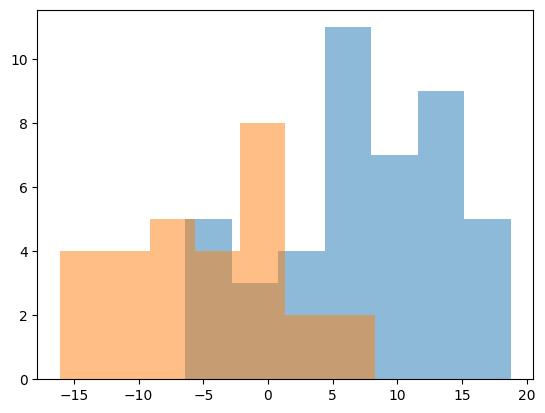

In [29]:
plt.hist(mia_regseason_advstats_w['eFG%_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_w['eFG%_diff']))
plt.hist(mia_regseason_advstats_l['eFG%_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_l['eFG%_diff']))

(array([4., 5., 3., 5., 8., 2., 2.]),
 array([-8.70316587, -6.20750139, -3.7118369 , -1.21617242,  1.27949207,
         3.77515655,  6.27082104,  8.76648553]),
 <BarContainer object of 7 artists>)

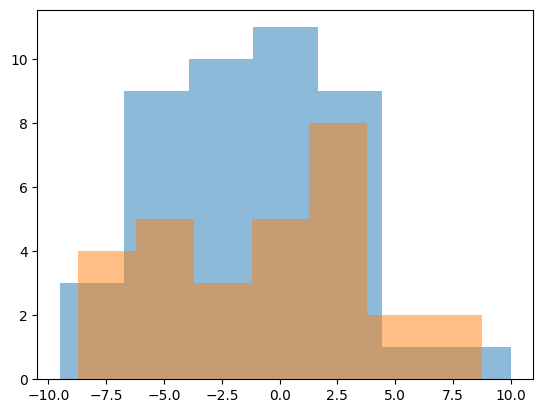

In [30]:
plt.hist(mia_regseason_advstats_w['TOV%_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_w['TOV%_diff']))
plt.hist(mia_regseason_advstats_l['TOV%_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_l['TOV%_diff']))

(array([5., 3., 4., 6., 6., 3., 2.]),
 array([-0.20363018, -0.15209117, -0.10055217, -0.04901316,  0.00252584,
         0.05406485,  0.10560385,  0.15714286]),
 <BarContainer object of 7 artists>)

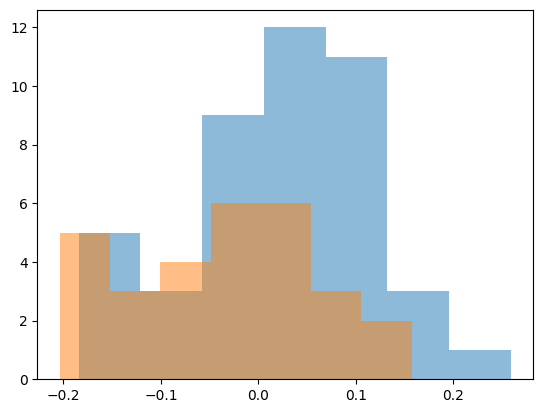

In [31]:
plt.hist(mia_regseason_advstats_w['ORB%_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_w['ORB%_diff']))
plt.hist(mia_regseason_advstats_l['ORB%_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_l['ORB%_diff']))

(array([1., 1., 6., 5., 6., 7., 3.]),
 array([-0.32012352, -0.24220949, -0.16429545, -0.08638142, -0.00846738,
         0.06944666,  0.14736069,  0.22527473]),
 <BarContainer object of 7 artists>)

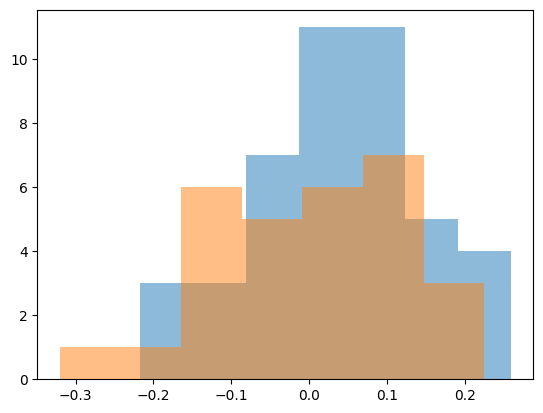

In [86]:
plt.hist(mia_regseason_advstats_w['FTRate_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_w['FTRate_diff']))
plt.hist(mia_regseason_advstats_l['FTRate_diff'], alpha=0.5, bins = retrieve_bin_count(mia_regseason_advstats_l['FTRate_diff']))

(array([ 2.,  0.,  0.,  7.,  0.,  0., 17.,  0.,  0.,  3.]),
 array([-4. , -3.4, -2.8, -2.2, -1.6, -1. , -0.4,  0.2,  0.8,  1.4,  2. ]),
 <BarContainer object of 10 artists>)

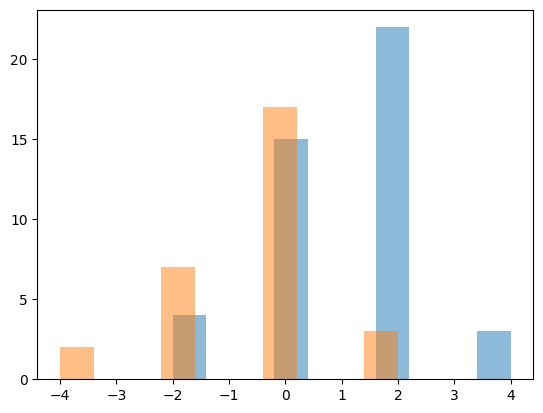

In [81]:
plt.hist(mia_regseason_advstats_w['FourFactorAdv'], alpha=0.5)
plt.hist(mia_regseason_advstats_l['FourFactorAdv'], alpha=0.5)

In [33]:
mia_regseason_advstats_mean = mia_regseason_full[advstats].groupby('TEAM_ID').mean()
mia_regseason_advstats_mean

,eFG%,OPP_eFG%,TOV%,OPP_TOV%,ORB%,OPP_ORB%,FTRate,OPP_FTRate,eFG%_diff,TOV%_diff,ORB%_diff,FTRate_diff
TEAM_ID,,,,,,,,,,,,
1610612748,54.878266,52.329831,13.488499,12.560998,0.201799,0.20358,0.237245,0.215911,2.548434,-0.927501,-0.00178,0.021335


In [87]:
mia_regseason_advstats_std = mia_regseason_full[advstats].groupby('TEAM_ID').std()
mia_regseason_advstats_std

,eFG%,OPP_eFG%,TOV%,OPP_TOV%,ORB%,OPP_ORB%,FTRate,OPP_FTRate,eFG%_diff,TOV%_diff,ORB%_diff,FTRate_diff,FourFactorAdv
TEAM_ID,,,,,,,,,,,,,
1610612748,6.742142,5.343626,4.005158,3.439042,0.060878,0.073601,0.091124,0.085424,8.873333,4.29286,0.099624,0.117266,1.707714


In [91]:
ind_regseason_advstats_mean = ind_regseason_full[advstats].groupby('TEAM_ID').mean()
ind_regseason_advstats_mean

,eFG%,OPP_eFG%,TOV%,OPP_TOV%,ORB%,OPP_ORB%,FTRate,OPP_FTRate,eFG%_diff,TOV%_diff,ORB%_diff,FTRate_diff,FourFactorAdv
TEAM_ID,,,,,,,,,,,,,
1610612754,53.563786,51.218348,11.974686,13.000783,0.197782,0.231601,0.172206,0.194406,2.345439,1.026097,-0.033819,-0.022199,0.068493


In [92]:
ind_regseason_advstats_std = ind_regseason_full[advstats].groupby('TEAM_ID').std()
ind_regseason_advstats_std

,eFG%,OPP_eFG%,TOV%,OPP_TOV%,ORB%,OPP_ORB%,FTRate,OPP_FTRate,eFG%_diff,TOV%_diff,ORB%_diff,FTRate_diff,FourFactorAdv
TEAM_ID,,,,,,,,,,,,,
1610612754,6.63337,6.09255,3.461118,2.830491,0.063656,0.076661,0.071986,0.067351,8.420776,4.264589,0.107242,0.086054,1.873268


In [97]:
print("Expected MIA eFG%: ")
(mia_regseason_advstats_mean['eFG%'].iloc[0] + ind_regseason_advstats_mean['OPP_eFG%'].iloc[0])/2

Expected MIA eFG%: 


53.04830670640564

In [98]:
print("Expected IND eFG%: ")
(mia_regseason_advstats_mean['OPP_eFG%'].iloc[0] + ind_regseason_advstats_mean['eFG%'].iloc[0])/2

Expected IND eFG%: 


52.94680886414535

In [104]:
print("Expected TOV ORB%: ")

(mia_regseason_advstats_mean['TOV%'].iloc[0] + ind_regseason_advstats_mean['OPP_TOV%'].iloc[0])/2

Expected TOV ORB%: 


13.244640759532064

In [59]:
print("Expected IND TOV%: ")

(mia_regseason_advstats_mean['OPP_TOV%'].iloc[0] + ind_regseason_advstats_mean['TOV%'].iloc[0])/2

12.267842048024086

In [103]:
print("Expected MIA ORB%: ")

(mia_regseason_advstats_mean['ORB%'].iloc[0] + ind_regseason_advstats_mean['OPP_ORB%'].iloc[0])/2

Expected MIA ORB%: 


0.21670023076233513

In [101]:
print("Expected IND ORB%: ")
(mia_regseason_advstats_mean['OPP_ORB%'].iloc[0] + ind_regseason_advstats_mean['ORB%'].iloc[0])/2

Expected IND ORB%: 


0.20068094813943466

In [102]:
print("Expected MIA FTRate: ")

(mia_regseason_advstats_mean['FTRate'].iloc[0] + ind_regseason_advstats_mean['OPP_FTRate'].iloc[0])/2

Expected MIA FTRate: 


0.21582548381173222

In [100]:
print("Expected IND FTRate: ")
(mia_regseason_advstats_mean['OPP_FTRate'].iloc[0] + ind_regseason_advstats_mean['FTRate'].iloc[0])/2

Expected IND FTRate: 


0.1940584699343749

From the above, we can see that MIA outclasses IND in at 3 of the 4 factors. From these, we expect that MIA should have a slight edge in beating IND. This is what happens in the first round of the 2020 playoffs, where MIA in fact beats IND 4-0 to advance to the second round against MIL. In the future, we will look at what other factors can potentially affect these statistics, and what other predictors are effective in determining game outcomes and win probabilities.

Although MIA's expected eFG% is around the same as IND's expected eFG%, MIA's eFG% is much higher than IND's expected opponent eFG%. In the future, we will look at factors that may wants us putting a heavier weight on MIA's eFG% over IND's OPP\_eFG%.

# Conclusion

In this notebook, we looked at MIA's season performance through Dean Oliver's Four Factors and determined that effective field goal percentage was the biggest variable in determining MIA winning or losing. We perform some deeper analysis to determine how MIA compares vs. IND in each of the four factors, and we can see that MIA outclasses IND in 3 of the 4 factors. 

This notebook is meant to serve as an introduction into the Four Factors and its potential uses. There is still a lot to be explored in terms of its predictive power, and what it means for teams with high rankings in these statistical features. In the future, we'll look at player specific statistics and how matchups play a factor in influencing the outcome of a game.

# References

[1] https://www.nbastuffer.com/analytics101/possession/ 

[2] https://www.basketball-reference.com/about/glossary.html#ft
